# Chapter 19: Improvement and its Principles

For additional context see Chapter 19 of [The Virus of Variation](https://www.brokenquality.com/book). Questions? Email James.Lehner@gmail.com or QualityIsBroken@gmail.com.

In [1]:
# Import libraries
from matplotlib import pyplot as plt
from matplotlib.ticker import FuncFormatter
from mpl_toolkits.mplot3d import Axes3D
import numpy as np
import seaborn as sns
import pandas as pd
from process_improvement import xmr_charts as xmr
import matplotlib.gridspec as gridspec

%matplotlib inline

## Helper function for process statistics

In [2]:
def calc_process_stats(df, value_col, mr_col, round_value=2,
                        E2=2.660, D4=3.268, print_results=False):
    """
    Calculate process limits and return them as a dictionary.

    Parameters
    ----------
    df : pandas.DataFrame
        DataFrame containing the data.
    value_col : str
        Column name for the individual values (e.g., 'Rate').
    mr_col : str
        Column name for the moving ranges (e.g., 'Moving Range').
    round_value : int
        Number of decimal places to round to.
    E2 : float
        Constant for calculating X chart limits.
    D4 : float
        Constant for calculating mR chart limits.
    print_results : str
        Print results for calculated statistics.

    Returns
    -------
    dict
        Dictionary with mean, average moving range, and process limits.
    """

    ave_mR = round(df[mr_col].mean(), round_value)
    mean = round(df[value_col].mean(), round_value)

    UPL = round(mean + (E2 * ave_mR), round_value)
    calc_LPL = round(mean - (E2 * ave_mR), round_value)
    LPL = max(0, calc_LPL)  # ensure LPL is not negative
    URL = round(D4 * ave_mR, round_value)
    
    results = {
        "Mean": mean,
        "Average mR": ave_mR,
        "UPL": UPL,
        "Calculated LPL": calc_LPL,
        "LPL": LPL,
        "URL": URL
    }
    
    if print_results == True:
        # Print results
        print("Process Statistics:")
        for key, value in results.items():
            print(f"  {key}: {value}")

    return results

## Get the data

This chapter uses three datasets.

The first dataset is Shewhart's resistance measurements. This file is called `shewharts-resistance-measurements.csv`. 

The second dataset is the death-to-birth rates for the baseline, first clinic, and second clinic. This file is called `improvement-death-to-birth-rates.csv`.

The third dataset is part placement data from an automated manufacturing process. This dataset called `wafer-placement-x-position.csv`.

The dataset can be found at https://github.com/jimlehner/the-virus-of-variation/tree/main/data.

In [3]:
# Get data function
def get_data(dataset_url) -> pd.DataFrame:
    return pd.read_csv(dataset_url)

## Get resistance data

In [4]:
# Death-to-birth rates for temporal comparison dataset url
resistance_url = r'https://raw.githubusercontent.com/jimlehner/the-virus-of-variation/refs/heads/main/data/shewharts-resistance-measurements.csv'

# Get data
resistance_df = get_data(resistance_url)

# Make 'Value' column dtype string
resistance_df['Value'] = resistance_df['Value'].astype('string')

# # Drop 'Note', 'Births', and 'Deaths' columns
resistance_df = resistance_df.drop('Units', axis=1)

# Show dataframe
resistance_df.head()

,Stage,Value,Resistance
0,Initial,1,5045
1,Initial,2,4350
2,Initial,3,4350
3,Initial,4,3975
4,Initial,5,4290


In [5]:
# Create initial_df
initial_df = resistance_df[resistance_df['Stage'] == 'Initial']

# Create additional_df
additional_df = resistance_df[resistance_df['Stage'] == 'Additional'].reset_index(drop=True)

# Show dataframe
additional_df

,Stage,Value,Resistance
0,Additional,1,4400
1,Additional,2,4565
2,Additional,3,4495
3,Additional,4,4325
4,Additional,5,4385
...,...,...,...
59,Additional,60,4565
60,Additional,61,4210
61,Additional,62,4540
62,Additional,63,4600


## Get improvement data

In [6]:
# Death-to-birth rates for temporal comparison dataset url
improvement_url = r'https://raw.githubusercontent.com/jimlehner/the-virus-of-variation/refs/heads/main/data/improvement-death-to-birth-rates.csv'

# Get data
improvement_df = get_data(improvement_url)

# Make 'Year' column dtype string
improvement_df['Year'] = improvement_df['Year'].astype('string')

# # Drop 'Note', 'Births', and 'Deaths' columns
improvement_df = improvement_df.drop(['Hospital', 
                                'Births', 
                                'Deaths'], axis=1)

# Show dataframe
improvement_df.head()

,Stage,Year,Rate
0,After pathological anatomy,1823,7.5
1,After pathological anatomy,1824,4.9
2,After pathological anatomy,1825,8.8
3,After pathological anatomy,1826,8.1
4,After pathological anatomy,1827,2.2


## Get wafer placement data

In [7]:
# Death-to-birth rates for temporal comparison dataset url
wafer_url = r'https://raw.githubusercontent.com/jimlehner/the-virus-of-variation/refs/heads/main/data/wafer-placement-x-position.csv'

# Get data
wafer_df = get_data(wafer_url)

# Make 'Value' column dtype string
wafer_df['Stage Index'] = wafer_df['Stage Index'].astype('string')

# # Drop 'Note', 'Births', and 'Deaths' columns
wafer_df = wafer_df.drop(['Index','Units'], axis=1)

# Show dataframe
wafer_df.head()

,Stage,Stage Index,X Position
0,Baseline,1,0.681
1,Baseline,2,0.565
2,Baseline,3,0.577
3,Baseline,4,0.572
4,Baseline,5,0.565


In [8]:
# Split wafer_df accoring to stages
baseline_df = wafer_df[wafer_df['Stage'] == 'Baseline']

change_df = wafer_df[wafer_df['Stage'] != 'Baseline'].reset_index(drop=True)
change_df

,Stage,Stage Index,X Position
0,Initial change,1,0.490
1,Initial change,2,0.467
2,Initial change,3,0.451
3,Initial change,4,0.513
4,Initial change,5,0.976
...,...,...,...
90,Initial change,91,0.708
91,Initial change,92,0.666
92,Initial change,93,0.512
93,Initial change,94,0.642


## Figure 19.1: Detective work

In [9]:
# Create empty dataframe
empty_df = pd.DataFrame()
empty_df['Value'] = pd.Series(dtype='float64')
empty_df['Resistance'] = pd.Series(dtype='float64')

# Create list of resistance dataframes
df_list = [initial_df, empty_df, additional_df]

# Create label_list
label_list = ['Unpredictable process', '', 'Predictable process']

In [10]:
# Constants for control limits
E2 = 2.660
D4 = 3.268

# Specify dataframe column as condition
condition = 'Resistance'
x_labels = 'Value' 

# Helper function to calculate statistics and limits
def calculate_limits(df, condition):
    mean = df[condition].mean()
    diff_amr = abs(df[condition].diff()).mean()
    UPL = mean + E2 * diff_amr
    LPL = max(mean - E2 * diff_amr, 0)
    URL = D4 * diff_amr
    return mean, diff_amr, UPL, LPL, URL

# Calculate statistics
stats = [calculate_limits(df, condition) for df in df_list]

# Isolate column to be used for x_labels
x_labels_for_plots = [df[x_labels] for df in df_list]

# Create results dataframe
parameters_df = pd.DataFrame(stats, columns=[r'$overline{x}$', 'AmR', 'UPL', 'LPL', 'URL'])
parameters_df['Labels'] = label_list
parameters_df['PLR'] = parameters_df['UPL'] - parameters_df['LPL']
parameters_df['data'] = [df[condition] for df in df_list]
parameters_df['mR'] = [abs(df[condition].diff()) for df in df_list]

# Determine predictability
parameters_df['Characterization'] = parameters_df.apply(
    lambda row: 'Predictable' if all(row['LPL'] <= x <= row['UPL'] for x in row['data']) else 'Unpredictable',
    axis=1
)

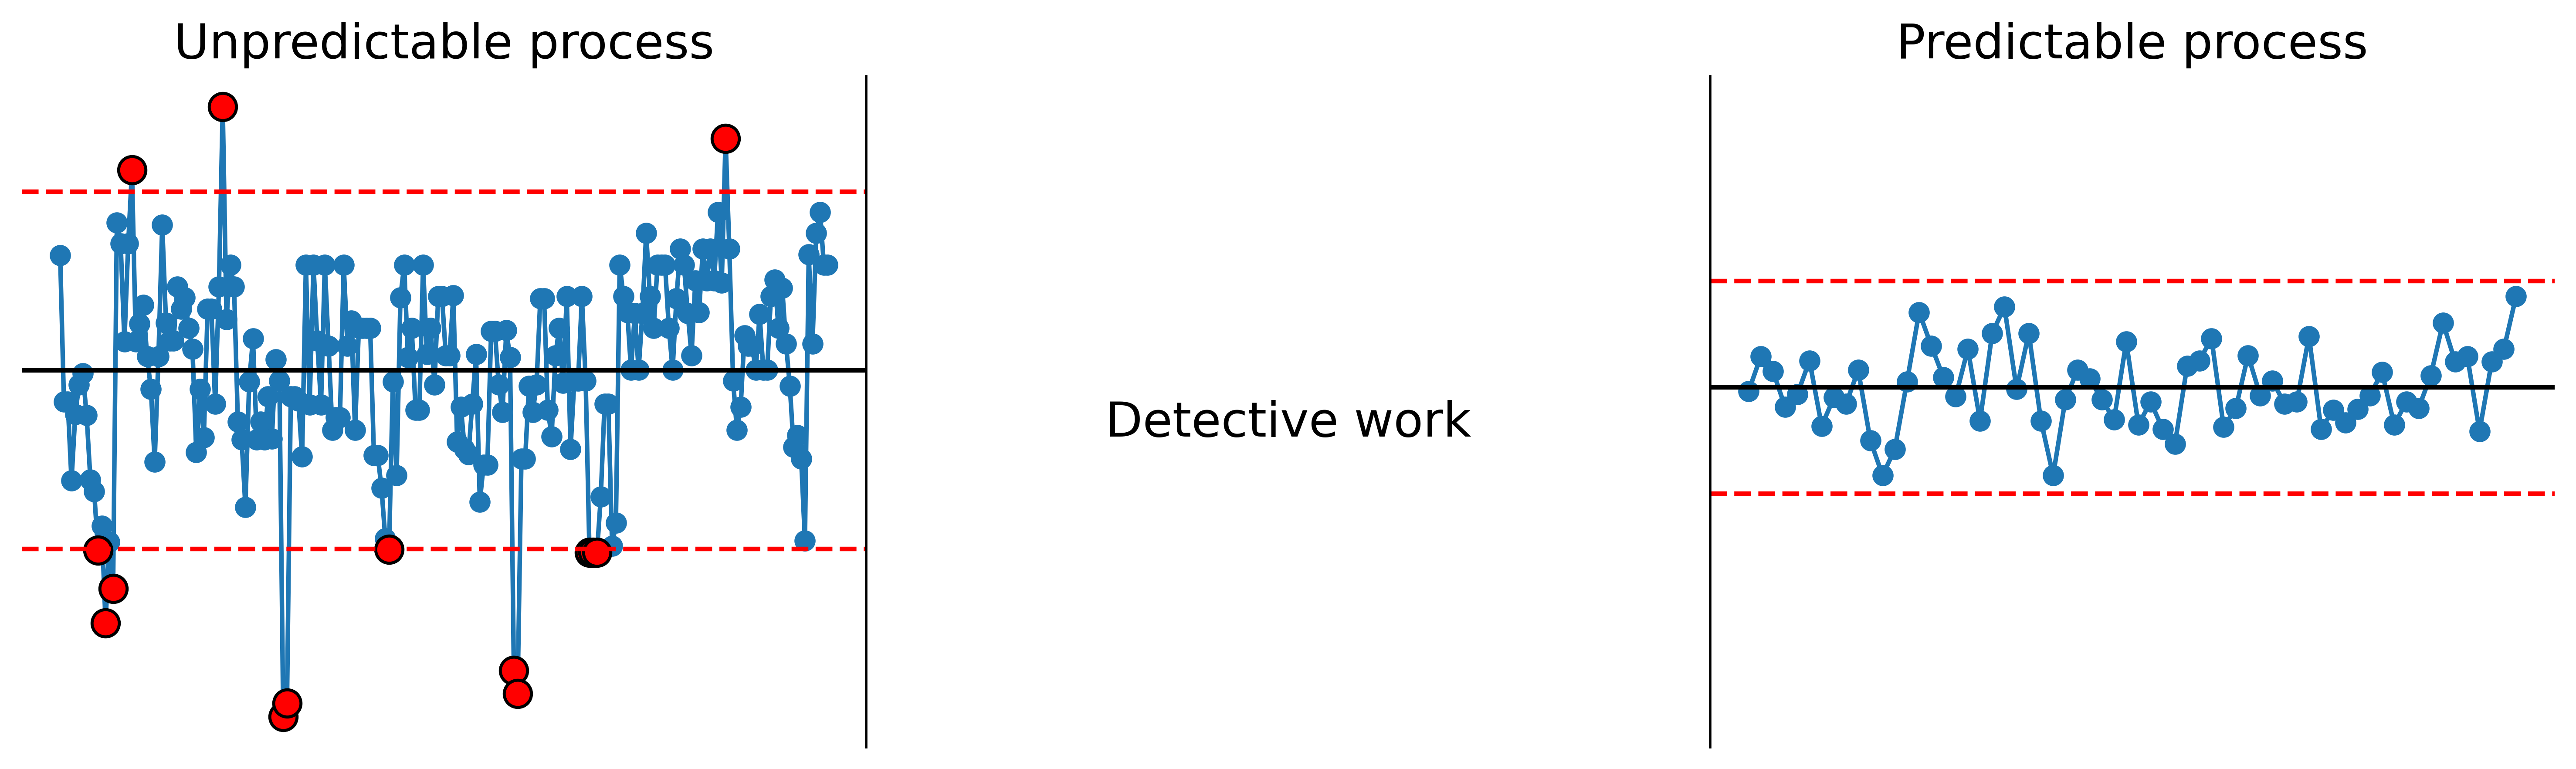

In [11]:
# Create figure and axes
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(15,4), sharey=True, dpi=500)
plt.subplots_adjust(wspace=0)
gs = gridspec.GridSpec(1, 3, width_ratios=[2, 1, 2]) 
# Flatten the axes
axes = axes.flatten() if isinstance(axes, np.ndarray) else [axes]

# Plot each dataset
for idx, (data, UPL, LPL, label, ax, x_labels) in enumerate(zip(
    parameters_df['data'], 
    parameters_df['UPL'], 
    parameters_df['LPL'], 
    parameters_df['Labels'], 
    axes,
    x_labels_for_plots)):

    # Plot data
    ax.plot(data, marker='o', ls='-')

    # Masking and plotting limits
    ax.plot(np.ma.masked_where(data < UPL, data), marker='o', ls='none', color='red', markeredgecolor='black', markersize=9)
    ax.plot(np.ma.masked_where(data > LPL, data), marker='o', ls='none', color='red', markeredgecolor='black', markersize=9)

    # Plotting lines for mean, UPL, and LPL
    mean = np.mean(data)
    ax.axhline(mean, ls='-', color='black')
    ax.axhline(UPL, ls='--', color='red')
    ax.axhline(LPL, ls='--', color='red')

    # Styling axes
    ax.grid(False)
    ax.set_title(label, fontsize=16)
    # Despine plot
    sns.despine()
    ax.tick_params(axis='y', which='both', length=0)
    ax.tick_params(axis='x', which='both')

    for ax in axes:
        ax.spines[['left']].set_alpha(1)
        ax.spines[['bottom']].set_alpha(0)
        ax.set_xticks([])
        ax.set_yticks([])

axes[1].spines[['bottom']].set_alpha(0)
axes[0].spines[['left']].set_alpha(0)

# Add annotation to center plot
axes[1].annotate('Detective work',
                 xy=(0, 4250),
                 ha='center', 
                 va='center',
                 fontsize=16
                )

# Show plot
plt.show()

## Figure 19.5: Alterations to a  process should be reversible until their impact is understood

In [12]:
# Create empty dataframe
wafer_empty_df = pd.DataFrame()
wafer_empty_df['Stage Index'] = pd.Series(dtype='float64')
wafer_empty_df['X Position'] = pd.Series(dtype='float64')

# Create list of resistance dataframes
wafer_df_list = [baseline_df, wafer_empty_df, change_df]

# Create label_list
wafer_label_list = ['Characterize the baseline', '', 'Has process improved?']
wafer_empty_df

,Stage Index,X Position


In [13]:
# Constants for control limits
E2 = 2.660
D4 = 3.268

# Specify dataframe column as condition
condition = 'X Position'
x_labels = 'Stage Index' 

# Helper function to calculate statistics and limits
def calculate_limits(df, condition):
    mean = df[condition].mean()
    diff_amr = abs(df[condition].diff()).mean()
    UPL = mean + E2 * diff_amr
    LPL = max(mean - E2 * diff_amr, 0)
    URL = D4 * diff_amr
    return mean, diff_amr, UPL, LPL, URL

# Calculate statistics
stats = [calculate_limits(wafer_df, condition) for wafer_df in wafer_df_list]

# Isolate column to be used for x_labels
x_labels_for_plots = [wafer_df[x_labels] for wafer_df in wafer_df_list]

# Create results dataframe
parameters_df = pd.DataFrame(stats, columns=['Mean', 'AmR', 'UPL', 'LPL', 'URL'])
parameters_df['Labels'] = wafer_label_list
parameters_df['PLR'] = parameters_df['UPL'] - parameters_df['LPL']
parameters_df['data'] = [wafer_df[condition] for wafer_df in wafer_df_list]
parameters_df['mR'] = [abs(wafer_df[condition].diff()) for df in wafer_df_list]

# Determine predictability
parameters_df['Characterization'] = parameters_df.apply(
    lambda row: 'Predictable' if all(row['LPL'] <= x <= row['UPL'] for x in row['data']) else 'Unpredictable',
    axis=1
)
parameters_df

,Mean,AmR,UPL,LPL,URL,Labels,PLR,data,mR,Characterization
0,0.543442,0.249660,1.207537,0.0,0.815887,Characterize the baseline,1.207537,0 0.681 1 0.565 2 0.577 3 0.57...,0 NaN 1 0.116 2 0.012 3 ...,Unpredictable
1,NaN,NaN,NaN,NaN,NaN,,NaN,"Series([], Name: X Position, dtype: float64)",0 NaN 1 0.116 2 0.012 3 ...,Predictable
2,0.617326,0.358819,1.571785,0.0,1.172621,Has process improved?,1.571785,0 0.490 1 0.467 2 0.451 3 0.51...,0 NaN 1 0.116 2 0.012 3 ...,Unpredictable


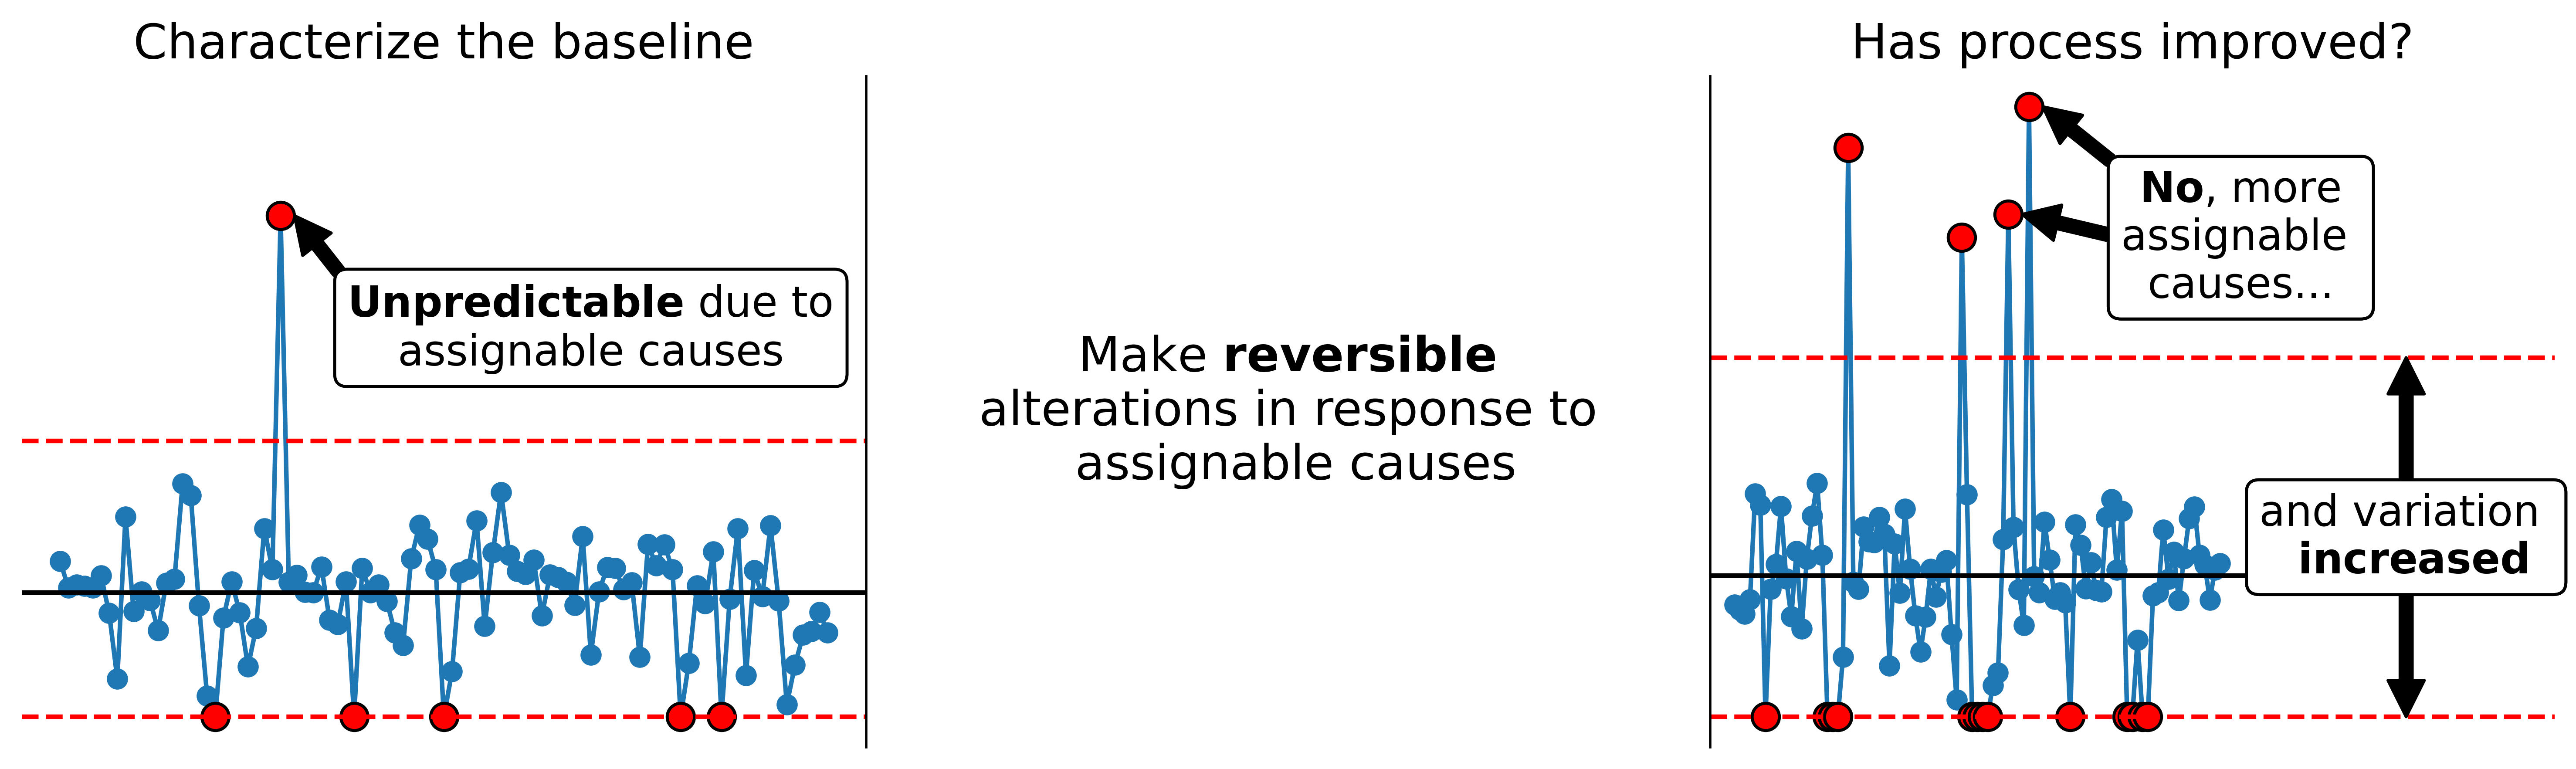

In [14]:
# Create figure and axes
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(15,4), sharey=True, dpi=500)
plt.subplots_adjust(wspace=0)
gs = gridspec.GridSpec(1, 3, width_ratios=[2, 1, 2]) 
# Flatten the axes
axes = axes.flatten() if isinstance(axes, np.ndarray) else [axes]

# Plot each dataset
for idx, (data, UPL, LPL, label, ax, x_labels) in enumerate(zip(
    parameters_df['data'], 
    parameters_df['UPL'], 
    parameters_df['LPL'], 
    parameters_df['Labels'], 
    axes,
    x_labels_for_plots)):

    # Plot data
    ax.plot(data, marker='o', ls='-')

    # Masking and plotting limits
    ax.plot(np.ma.masked_where(data < UPL, data), marker='o', ls='none', color='red', markeredgecolor='black', markersize=9)
    ax.plot(np.ma.masked_where(data > LPL, data), marker='o', ls='none', color='red', markeredgecolor='black', markersize=9)

    # Plotting lines for mean, UPL, and LPL
    mean = np.mean(data)
    ax.axhline(mean, ls='-', color='black')
    ax.axhline(UPL, ls='--', color='red')
    ax.axhline(LPL, ls='--', color='red')

    # Styling axes
    ax.grid(False)
    ax.set_title(label, fontsize=16)
    # Despine plot
    sns.despine()
    ax.tick_params(axis='y', which='both', length=0)
    ax.tick_params(axis='x', which='both')

    for ax in axes:
        ax.spines[['left']].set_alpha(1)
        ax.spines[['bottom']].set_alpha(0)
        ax.set_xticks([])
        ax.set_yticks([])
        
    # Extend x-axis by 5 units
    x_min, x_max = axes[idx].get_xlim()
    if idx == 2:
        axes[idx].set_xlim(x_min, x_max + 60)

# Set alpha values for spines
axes[1].spines[['bottom']].set_alpha(0)
axes[0].spines[['left']].set_alpha(0)

# Calculate process limit range (PLR) for change_df
change_PLR = (parameters_df['UPL'][2]-parameters_df['LPL'][2])/2

# Define annotations (text, xy-coordinates, xytext-coordinates)
annotations = [
    ('$\mathbf{Unpredictable}$ due to \nassignable causes', (28.7,2.193),(65,1.7), 0),
    ('$\mathbf{No}$, more \nassignable \ncauses...', (59.7, 2.670),(98, 2.097), 2),
    ('$\mathbf{No}$, more \nassignable \ncauses...', (55.7, 2.199),(98, 2.097), 2),
    ('and variation \n $\mathbf{increased}$', (130, parameters_df['UPL'][2]),(130, change_PLR), 2),
    ('and variation \n $\mathbf{increased}$', (130, parameters_df['LPL'][2]),(130, change_PLR), 2)
]

# Add annotations using a loop
for text, xy, xytext, subplot in annotations:
    axes[subplot].annotate(text, xy=xy, xytext=xytext,
                ha='center', va='center', fontsize=14,
                bbox=dict(facecolor='white', edgecolor='black', boxstyle='round'),
                arrowprops=dict(facecolor='black')) 

# Add description annotation to center plot
axes[1].annotate('Make $\mathbf{reversible}$ \nalterations in response to\n assignable causes',
                 xy=(0, 1.335),
                 ha='center', 
                 va='center',
                 fontsize=16
                )

max_y = change_df['X Position'].max()
# Show plot
plt.show()

## Figure 19.6: XmR chart of death-to-birth rates after pathological anatomy began

In [15]:
# Get unique stages in improvement_df
stage_list = improvement_df['Stage'].unique().tolist()

# Create dataframe list
vienna_df_list = []
for stage in stage_list:
    # Create stage_df
    stage_df = improvement_df[improvement_df['Stage'] == stage].reset_index(drop=True)
    
    # Calculate moving range
    stage_df['Moving Range'] = abs(stage_df['Rate'].diff())
    
    # Append stage_df to list
    vienna_df_list.append(stage_df)

In [16]:
# Calculate baseline process statistics
baseline_stats = calc_process_stats(vienna_df_list[0], 'Rate', 'Moving Range')

# Show results
baseline_stats

{'Mean': 5.91,
 'Average mR': 2.62,
 'UPL': 12.88,
 'Calculated LPL': -1.06,
 'LPL': 0,
 'URL': 8.56}

In [17]:
# Specify round_value
round_value = 2
tickinterval = 1

stats = baseline_stats

# Prepare data for plotting
data = vienna_df_list[0]['Rate']
moving_range = round(abs(data.diff()),round_value)
labels = vienna_df_list[0]['Year']

# --- Masking parameters ---
upper_lim = np.ma.masked_where(data < stats['UPL'], data)
lower_lim = np.ma.masked_where(data > stats['LPL'], data)

url_greater = np.ma.masked_where(moving_range <= stats['URL'], moving_range)

# --- Line styles and colors ---
x_limits = ['Mean', 'UPL', 'LPL']
mr_limits = ['Average mR', 'URL']

# Map each limit to its linestyle/color
line_styles = {
    'Mean': ('-', 'black'),
    'Average mR': ('-', 'black'),
    'UPL': ('--', 'red'),
    'LPL': ('--', 'red'),
    'URL': ('--', 'red')
}

# --- Create lines and labels dynamically ---
xchart_lines  = [(stats[k], *line_styles[k]) for k in x_limits]
mrchart_lines = [(stats[k], *line_styles[k]) for k in mr_limits]

xchart_labels = [(stats[k], stats[k]) for k in x_limits]
mrchart_labels = [(stats[k], stats[k]) for k in mr_limits]

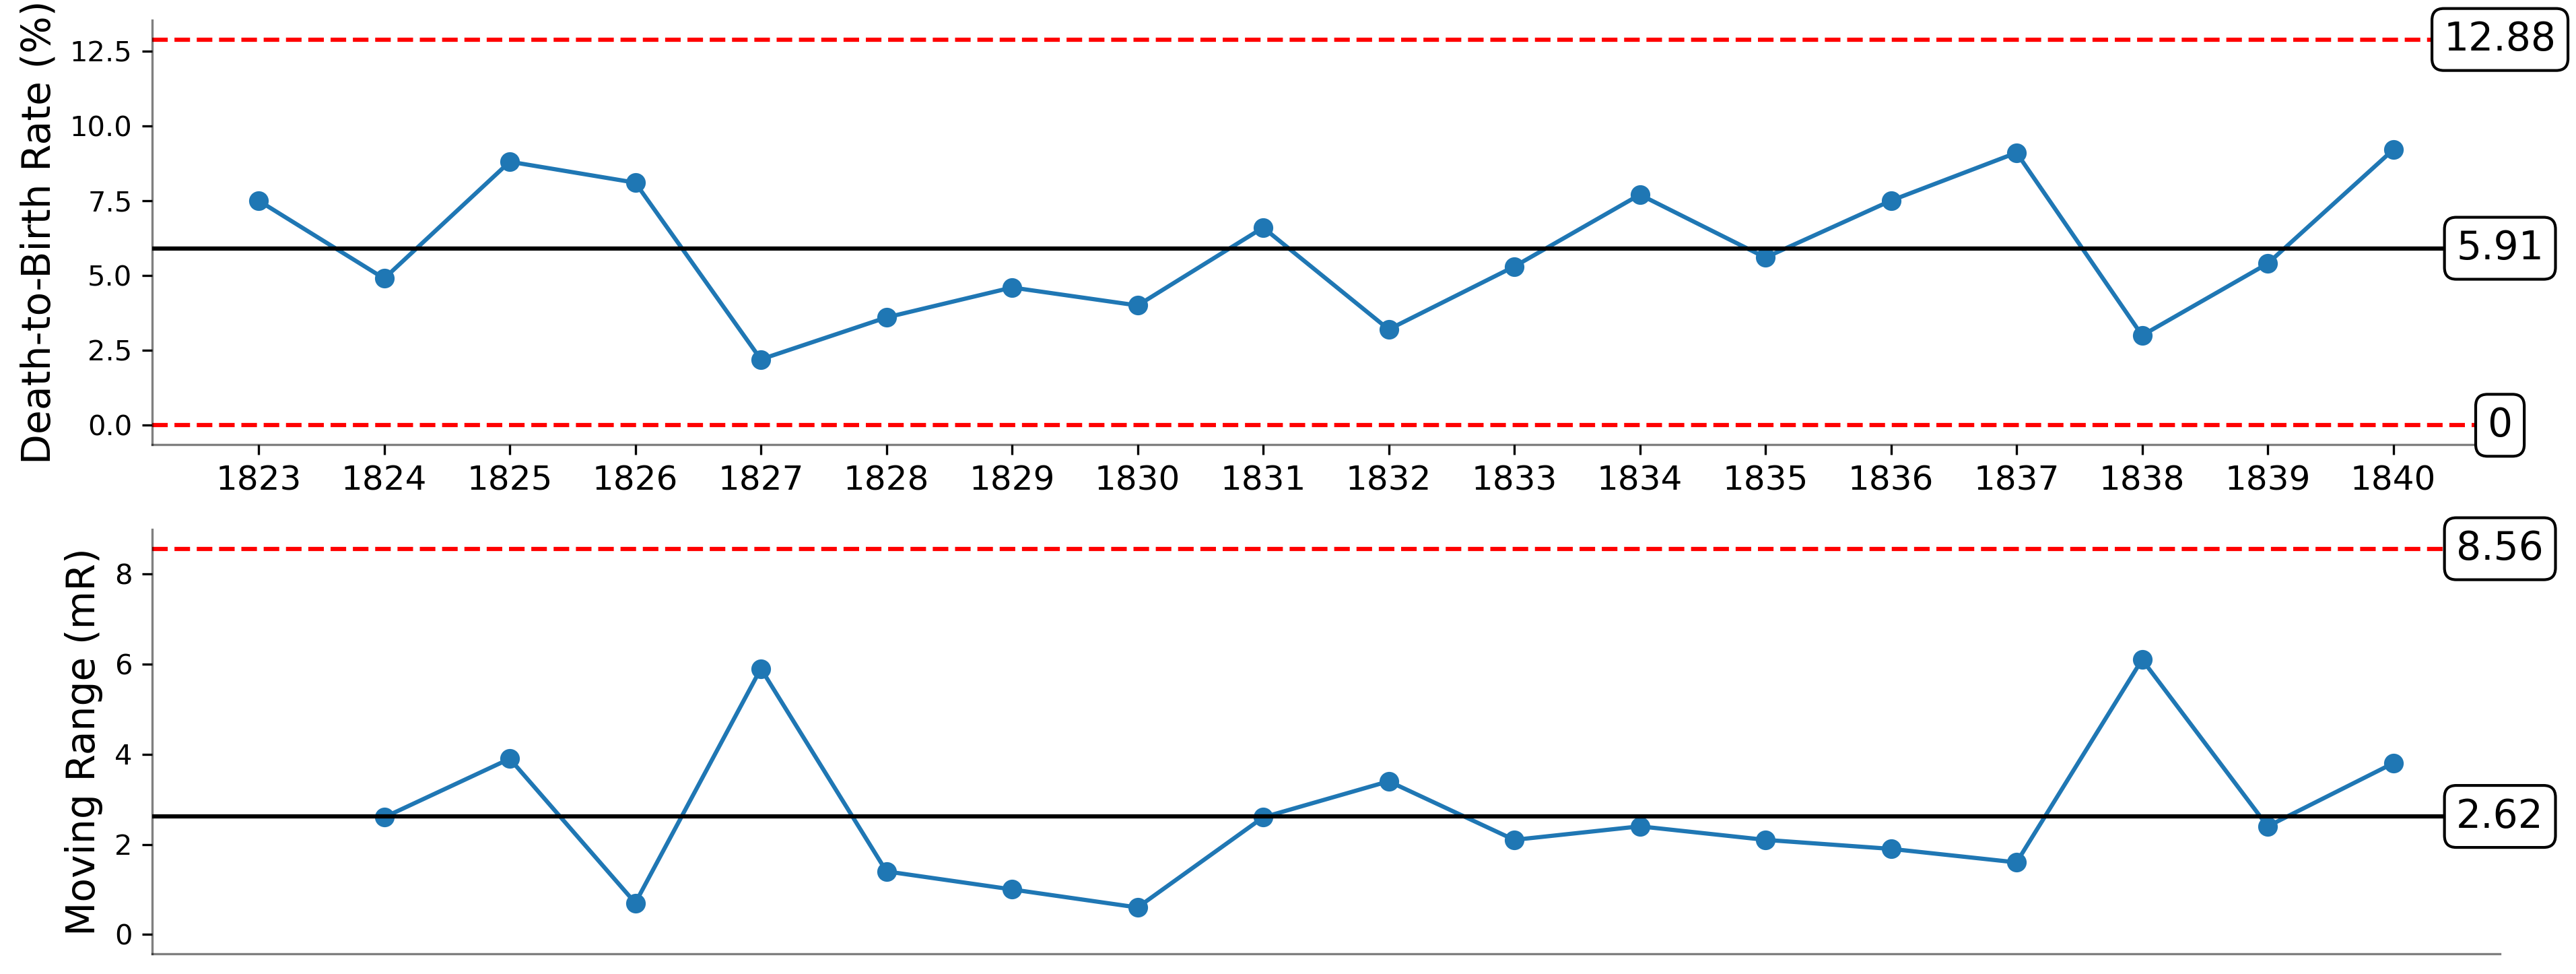

In [18]:
# --- Figure & Axes ---
fig, ax = plt.subplots(2, 1, figsize=(15, 6), dpi=300)

# --- Plot main data ---
ax[0].plot(labels, data, marker='o', label='X data')
ax[1].plot(labels, moving_range, marker='o', label='mR data')

# Create masking parameters for values beyond process limits
masked_values = {
    "upper_lim": np.ma.masked_where(data < stats['UPL'], data),
    "lower_lim": np.ma.masked_where(data >  stats['LPL'], data),
    "url_greater": np.ma.masked_where(moving_range <= stats['URL'], moving_range)
}

# Function to highlight points outside process limits
def highlight_assignable_causes(ax, labels, masked_values, color='tab:red', size=9):
    for key, masked_data in masked_values.items():
        ax.plot(labels, masked_data, marker='o', ls='none', color=color,
                markeredgecolor='black', markersize=size)

# Apply outlier highlighting
highlight_assignable_causes(ax[0], labels, {"upper_lim": masked_values["upper_lim"], "lower_lim": masked_values["lower_lim"]})
highlight_assignable_causes(ax[1], labels, {"url_greater": masked_values["url_greater"]})

# Offset moving ranges by plotting invisible x’s where values are NaN
for xi, yi in zip(labels, moving_range):
    if np.isnan(yi):
        ax[1].plot(xi, 0, marker='x', color='white', markersize=0)

# --- Add process limit & centerline lines ---
for value, linestyle, color in xchart_lines:
    ax[0].axhline(value, ls=linestyle, color=color)
for value, linestyle, color in mrchart_lines:
    ax[1].axhline(value, ls=linestyle, color=color)

# --- Add text labels for limits & centerlines ---
bbox_props = dict(boxstyle="round,pad=0.3", fc="white", ec="black", lw=1)
for y_val, label in xchart_labels:
    ax[0].text(
        ax[0].get_xlim()[1], y_val, label,
        ha='center', va='center', fontsize=14, bbox=bbox_props
    )
for y_val, label in mrchart_labels:
    ax[1].text(
        ax[1].get_xlim()[1], y_val, label,
        ha='center', va='center', fontsize=14, bbox=bbox_props
    )

# --- Aesthetics ---
sns.despine()
for val in range(0,2):
    ax[val].spines[['left', 'bottom']].set_alpha(0.5)

# --- X-axis formatting ---
tick_interval = tickinterval
tick_positions = np.arange(0, len(labels), tick_interval)
ax[0].set_xticks(tick_positions)
ax[0].set_xticklabels(labels.iloc[tick_positions], fontsize=12)
ax[1].set_xticks([])  # remove ticks from lower chart

# --- Labels ---
ax[0].set_ylabel("Death-to-Birth Rate (%)", fontsize=14)
ax[1].set_ylabel("Moving Range (mR)", fontsize=14)

# plt.tight_layout()
plt.show()

## Figure 19.7: XmR chart comparing baseline with clinics

In [19]:
df_list = vienna_df_list
subplot_titles_list = ['After Pathological Anatomy \n(Baseline)', 
                       '1st Clinic \n(Only Male Students)', 
                       '2nd Clinc \n(Only female Students)']

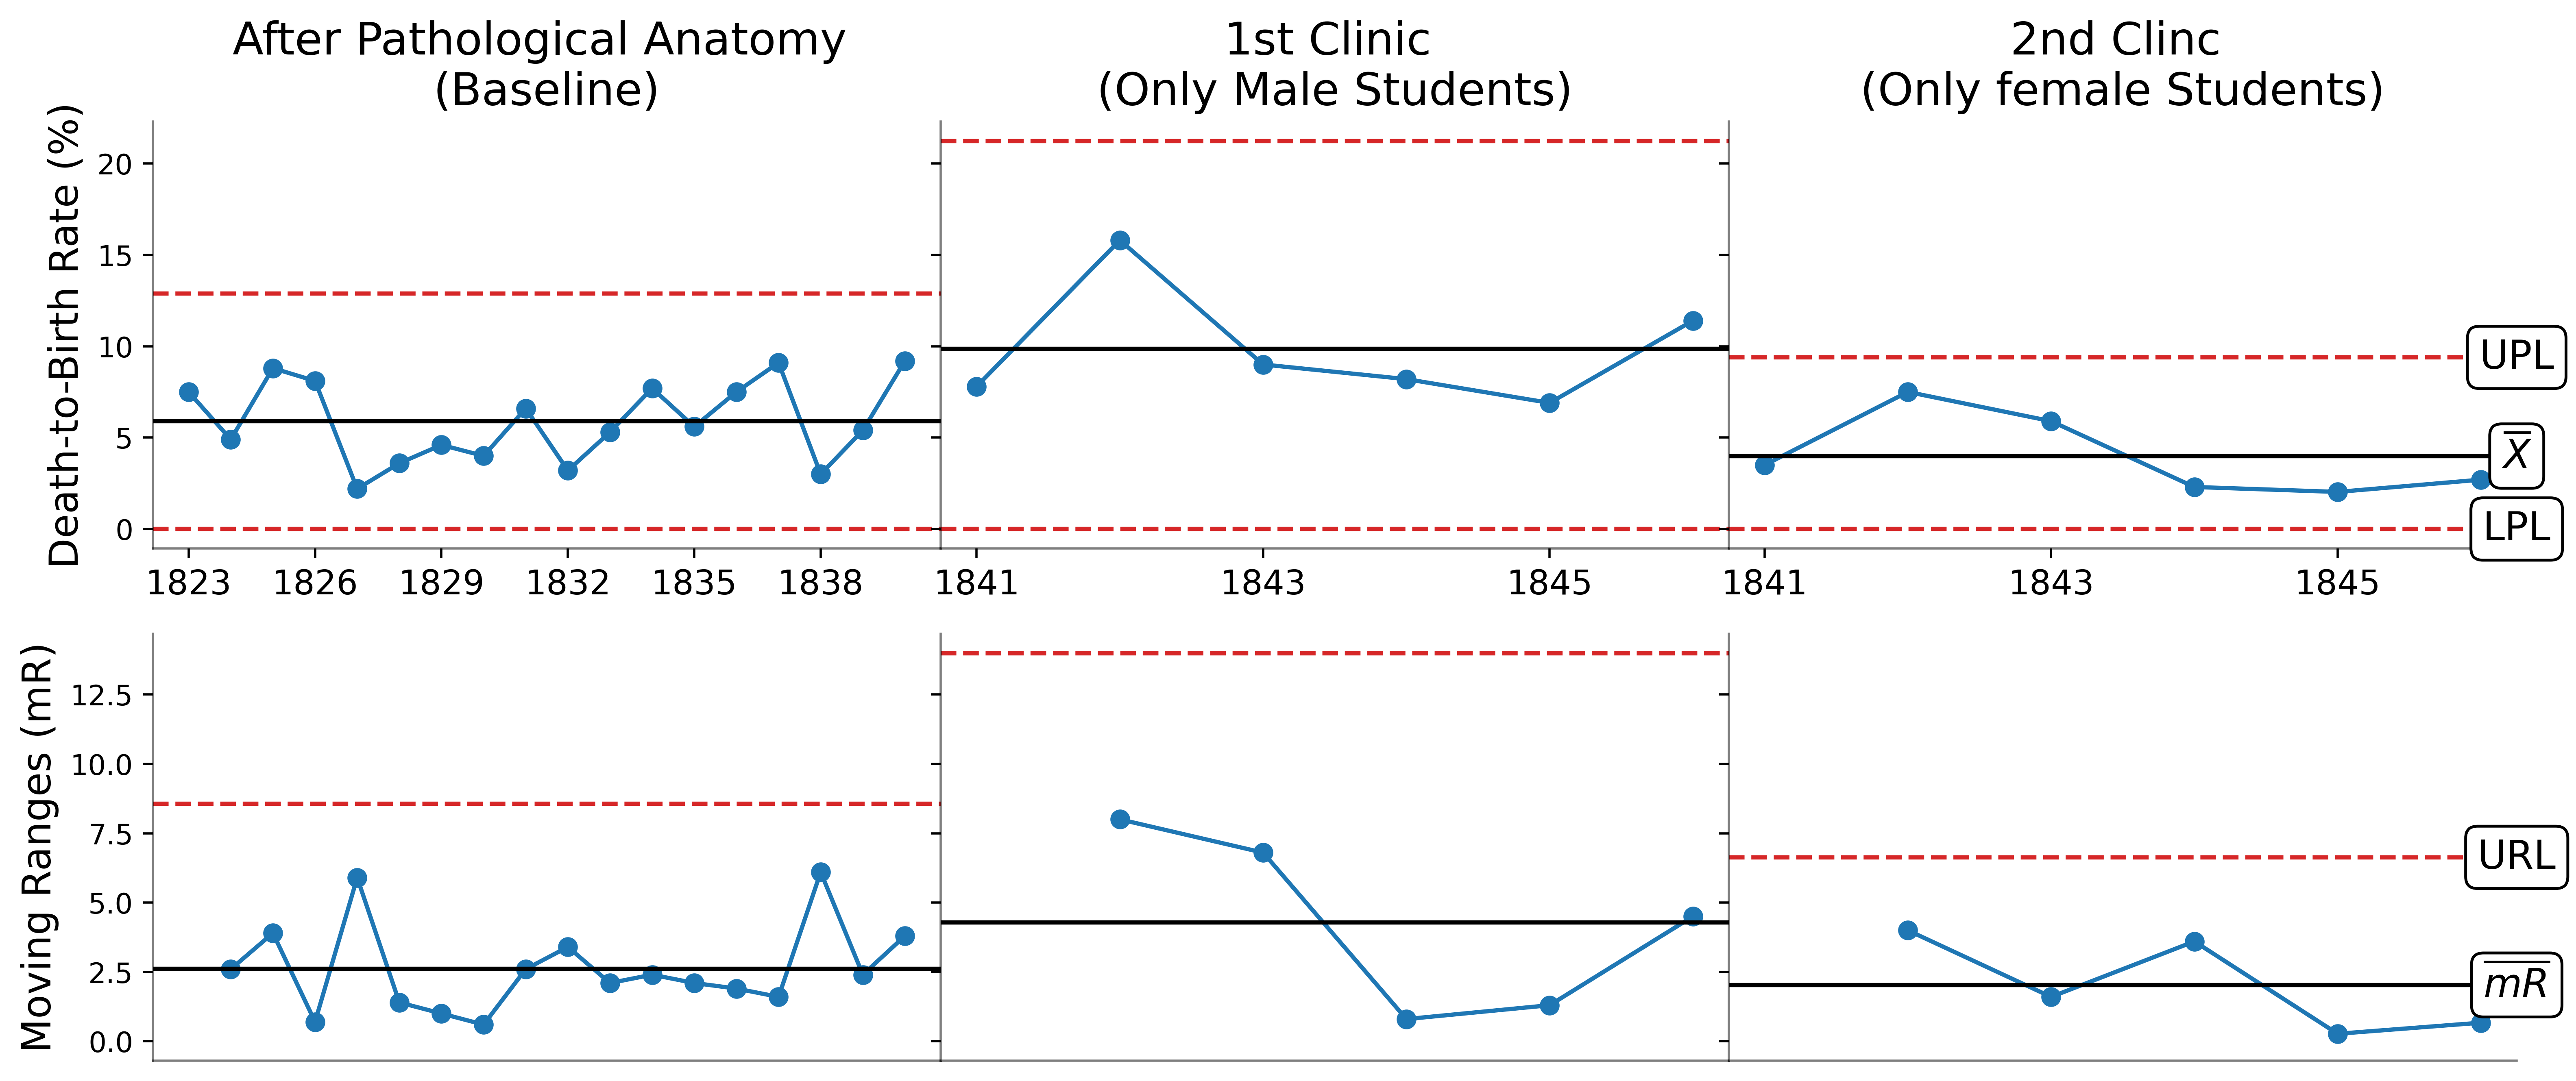

In [20]:
# Specify round_value
round_value = 2
global_tick_interval = 3
local_tick_interval = 2

# Specify condition
condition = 'Rate'
labels = 'Year'

# Define plotting parameters
fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(15, 6), dpi=500, sharey='row')
plt.subplots_adjust(wspace=0)

# Initialize an empty list to store stats for each dataframe
stats_list = []

# Loop through the df_list and plot on the axes
for idx, (df, label) in enumerate(zip(df_list, subplot_titles_list)):

    data = df[condition]
    moving_range = round(abs(data.diff()), round_value).copy()
    moving_range.iloc[0] = np.nan
    xticks = df[labels]

    # Specify scaling factors
    E2 = 2.660
    D4 = 3.268

    # Calculate statistics for UPL and LPL
    mean = round(data.mean(), round_value)
    average_mR = round(moving_range.mean(), round_value)
    UPL = round(mean + (E2 * average_mR), round_value)
    LPL = round(max(mean - (E2 * average_mR), 0), round_value)
    URL = round(D4 * average_mR, round_value)

    # Characterize process
    if ((data < LPL) | (data > UPL)).any():
        characterization = "Unpredictable"
    elif (moving_range > URL).any():  # Add condition for moving range exceeding the URL
        characterization = "Unpredictable"
    else:
        characterization = "Predictable"

    # Store statistics in the list
    stats_list.append({
        'Label': label,
        'Mean': mean,
        'Ave. mR': average_mR,
        'UPL': UPL,
        'LPL': LPL,
        'URL': URL,
        'PRL': UPL-LPL,
        'Characterization': characterization
    })

    # Plot individual values in the first two subplots (top row)
    axes[0, idx].plot(data, marker='o')
    # Masking and plotting limits
    axes[0, idx].plot(np.ma.masked_where(data < UPL, data), marker='o', ls='none', color='red', markeredgecolor='black', markersize=9)
    axes[0, idx].plot(np.ma.masked_where(data > LPL, data), marker='o', ls='none', color='red', markeredgecolor='black', markersize=9)
    axes[0, idx].set_title(label, fontsize=16)

    # Add UPL and LPL horizontal lines for individual values plot
    axes[0, idx].axhline(UPL, color='tab:red', linestyle='--')
    axes[0, idx].axhline(LPL, color='tab:red', linestyle='--')
    axes[0, idx].axhline(mean, color='black', linestyle='-')
    
    # Choose tick interval for each subplot
    if idx in [1, 2]:
        tick_interval = local_tick_interval    # denser ticks for plots 1 and 2
    else:
        tick_interval = global_tick_interval  
    
    # Set x-tick labels with separate intervals
    tick_positions = np.arange(0, len(xticks), tick_interval)
        
    axes[0, idx].set_xticks(tick_positions)
    axes[0, idx].set_xticklabels(xticks.iloc[tick_positions], rotation=0, ha='center', fontsize=12)

    # Plot moving range in the second row
    axes[1, idx].plot(moving_range, marker='o')
    
    # Offset moving range by 1 relative to the individual values
    for xi, yi in zip(labels, moving_range):
        if np.isnan(yi):
            axes[1, idx].plot(xi, 0, marker='x', color='white', markersize=0)

    # Add UPL and LPL horizontal lines for moving range plot
    axes[1, idx].axhline(URL, color='tab:red', linestyle='--')
    axes[1, idx].axhline(average_mR, color='black', linestyle='-')
    axes[1, idx].plot(np.ma.masked_where(moving_range < URL, moving_range), marker='o', ls='none', color='red', markeredgecolor='black', markersize=9)

    # Add label to y-axes
    axes[0, 0].set_ylabel('Death-to-Birth Rate (%)', fontsize=14)
    axes[1, 0].set_ylabel('Moving Ranges (mR)', fontsize=14)
    
    # Establish bbox properties
    bbox_props = dict(boxstyle="round,pad=0.3", fc="white", ec="black", lw=1)

    # Add labels to 2nd and 4th plots
    if idx == 2:
        axes[0, idx].text(axes[0, idx].get_xlim()[1], UPL, 'UPL', color='black', ha='center', va='center',
                          fontsize=14, bbox=bbox_props)
        axes[0, idx].text(axes[0, idx].get_xlim()[1], LPL, 'LPL', color='black', ha='center', va='center', 
                          fontsize=14, bbox=bbox_props)
        axes[0, idx].text(axes[0, idx].get_xlim()[1], mean, r'$\overline{X}$', color='black', ha='center', va='center',
                          fontsize=14, bbox=bbox_props)

    if idx == 2:
        axes[1, idx].text(axes[1, idx].get_xlim()[1], URL, 'URL', color='black', ha='center', va='center', 
                          fontsize=14, bbox=bbox_props)
        axes[1, idx].text(axes[1, idx].get_xlim()[1], average_mR, r'$\overline{mR}$', 
                          color='black', ha='center', va='center', 
                          fontsize=14, bbox=bbox_props)

    # Remove ticks on xticks for moving ranges
    axes[1, idx].set_xticks([])
    
    # Loop through the axes and set spine width
    for ax_row in axes:
        for ax in ax_row:
            for spine in ax.spines.values():
                spine.set_alpha(0.5)

# Stylize plots
sns.despine()
    
# Convert stats list into DataFrame
stats_df = pd.DataFrame(stats_list)

In [21]:
stats_df

,Label,Mean,Ave. mR,UPL,LPL,URL,PRL,Characterization
0,After Pathological Anatomy \n(Baseline),5.91,2.62,12.88,0,8.56,12.88,Predictable
1,1st Clinic \n(Only Male Students),9.85,4.28,21.23,0,13.99,21.23,Predictable
2,2nd Clinc \n(Only female Students),3.99,2.03,9.39,0,6.63,9.39,Predictable


## Figure 19.8: Comparison of clinics

In [22]:
clinic_df_list = vienna_df_list[1:]
clinic_titles_list = [ '1st Clinic (Only Male Students)',
                       '2nd Clinc (Only Female Students)']

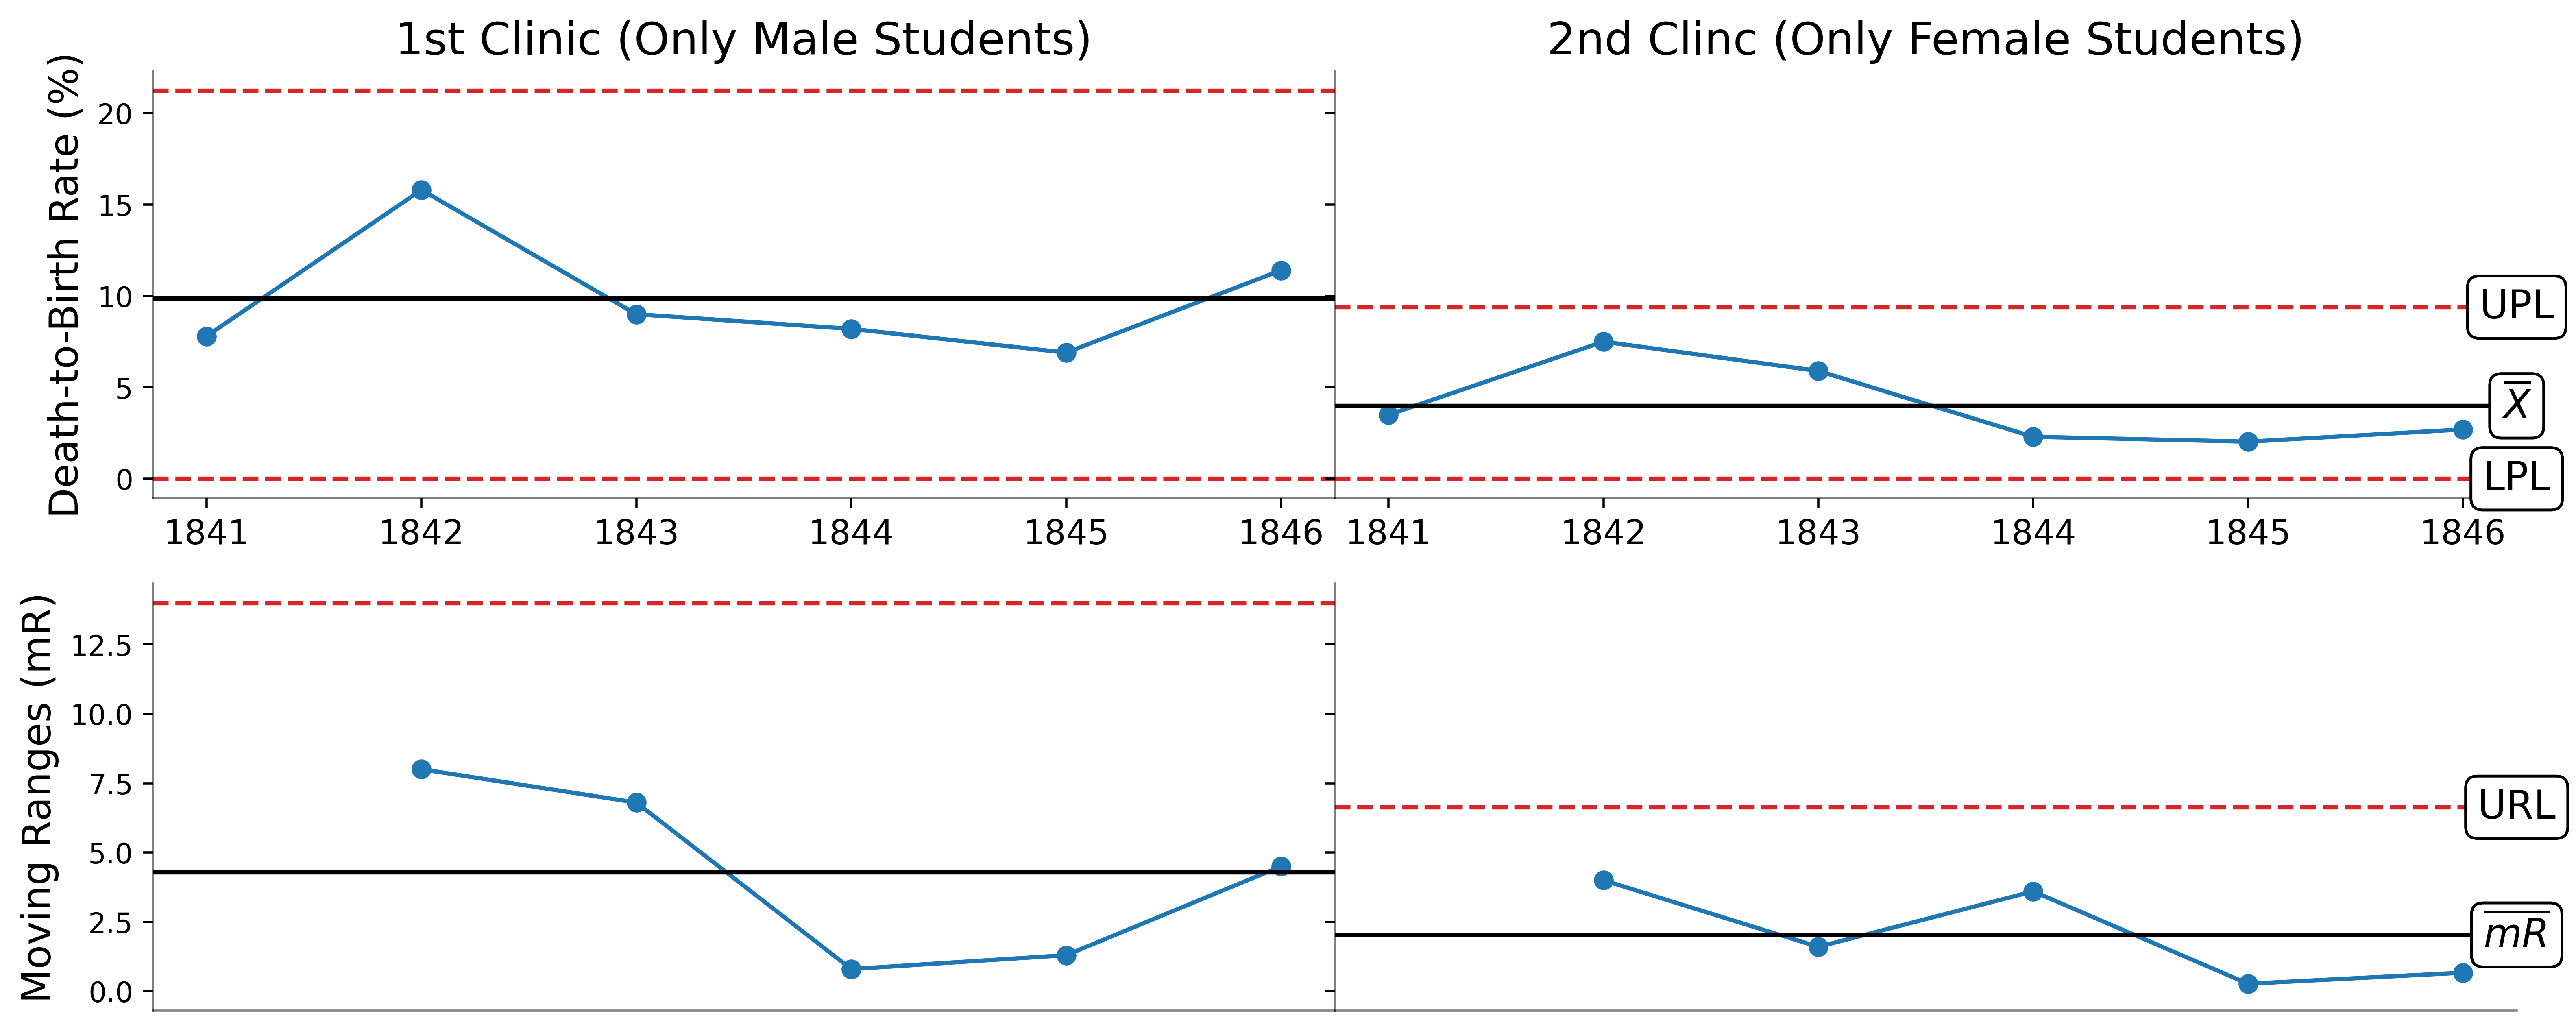

In [23]:
# Specify round_value and tickinterval
round_value = 2
tickinterval = 1

# Specify condition
condition = 'Rate'
labels = 'Year'

# Specify df_list and plot_label_list
df_list = clinic_df_list
plot_label_list = clinic_titles_list

# Define plotting parameters
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(15, 6), dpi=500, sharey='row')
plt.subplots_adjust(wspace=0)

# Initialize an empty list to store stats for each dataframe
stats_list = []

# Loop through the df_list and plot on the axes
for idx, (df, label) in enumerate(zip(df_list, plot_label_list)):

    data = df[condition]
    moving_range = round(abs(data.diff()), round_value).copy()
    moving_range.iloc[0] = np.nan
    xticks = df[labels]

    # Specify scaling factors
    E2 = 2.660
    D4 = 3.268

    # Calculate statistics for UPL and LPL
    mean = round(data.mean(), round_value)
    average_mR = round(moving_range.mean(), round_value)
    UPL = round(mean + (E2 * average_mR), round_value)
    LPL = round(max(mean - (E2 * average_mR), 0), round_value)
    URL = round(D4 * average_mR, round_value)

    # Characterize process
    if ((data < LPL) | (data > UPL)).any():
        characterization = "Unpredictable"
    elif (moving_range > URL).any():  # Add condition for moving range exceeding the URL
        characterization = "Unpredictable"
    else:
        characterization = "Predictable"

    # Store statistics in the list
    stats_list.append({
        'Label': label,
        'Mean': mean,
        'Ave. mR': average_mR,
        'UPL': UPL,
        'LPL': LPL,
        'URL': URL,
        'PRL': UPL-LPL,
        'Characterization': characterization
    })

    # Plot individual values in the first two subplots (top row)
    axes[0, idx].plot(data, marker='o')
    # Masking and plotting limits
    axes[0, idx].plot(np.ma.masked_where(data < UPL, data), marker='o', ls='none', color='red', markeredgecolor='black', markersize=9)
    axes[0, idx].plot(np.ma.masked_where(data > LPL, data), marker='o', ls='none', color='red', markeredgecolor='black', markersize=9)
    axes[0, idx].set_title(label, fontsize=16)

    # Add UPL and LPL horizontal lines for individual values plot
    axes[0, idx].axhline(UPL, color='tab:red', linestyle='--')
    axes[0, idx].axhline(LPL, color='tab:red', linestyle='--')
    axes[0, idx].axhline(mean, color='black', linestyle='-')
    
    # Set x-tick labels with separate intervals
    tick_positions = np.arange(0, len(xticks), tickinterval)
        
    axes[0, idx].set_xticks(tick_positions)
    axes[0, idx].set_xticklabels(xticks.iloc[tick_positions], rotation=0, ha='center', fontsize=12)

    # Plot moving range in the second row
    axes[1, idx].plot(moving_range, marker='o')
    
    # Offset moving range by 1 relative to the individual values
    for xi, yi in zip(labels, moving_range):
        if np.isnan(yi):
            axes[1, idx].plot(xi, 0, marker='x', color='white', markersize=0)

    # Add UPL and LPL horizontal lines for moving range plot
    axes[1, idx].axhline(URL, color='tab:red', linestyle='--')
    axes[1, idx].axhline(average_mR, color='black', linestyle='-')
    axes[1, idx].plot(np.ma.masked_where(moving_range < URL, moving_range), marker='o', ls='none', color='red', markeredgecolor='black', markersize=9)

    # Add label to y-axes
    axes[0, 0].set_ylabel('Death-to-Birth Rate (%)', fontsize=14)
    axes[1, 0].set_ylabel('Moving Ranges (mR)', fontsize=14)
    
    # Establish bbox properties
    bbox_props = dict(boxstyle="round,pad=0.3", fc="white", ec="black", lw=1)

    # Add labels to 2nd and 4th plots
    if idx == 1:
        axes[0, idx].text(axes[0, idx].get_xlim()[1], UPL, 'UPL', color='black', ha='center', va='center',
                          fontsize=14, bbox=bbox_props)
        axes[0, idx].text(axes[0, idx].get_xlim()[1], LPL, 'LPL', color='black', ha='center', va='center', 
                          fontsize=14, bbox=bbox_props)
        axes[0, idx].text(axes[0, idx].get_xlim()[1], mean, r'$\overline{X}$', color='black', ha='center', va='center',
                          fontsize=14, bbox=bbox_props)

    if idx == 1:
        axes[1, idx].text(axes[1, idx].get_xlim()[1], URL, 'URL', color='black', ha='center', va='center', 
                          fontsize=14, bbox=bbox_props)
        axes[1, idx].text(axes[1, idx].get_xlim()[1], average_mR, r'$\overline{mR}$', 
                          color='black', ha='center', va='center', 
                          fontsize=14, bbox=bbox_props)

    # Remove ticks on xticks for moving ranges
    axes[1, idx].set_xticks([])
    
    # Loop through the axes and set spine width
    for ax_row in axes:
        for ax in ax_row:
            for spine in ax.spines.values():
                spine.set_alpha(0.5)

# Stylize plots
sns.despine()
    
# Convert stats list into DataFrame
physical_stats_df = pd.DataFrame(stats_list)